**Image2Image Pipeline for Stable Diffusion using Gradio**

In [20]:
!nvidia-smi

Tue Oct 31 14:56:00 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.113.01             Driver Version: 535.113.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-32GB           Off | 00000000:62:00.0 Off |                    0 |
| N/A   47C    P0              65W / 300W |   5005MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [21]:
!pip install -qq -U transformers ftfy gradio diffusers

In [22]:
!pip install -qq "ipywidgets>=7,<8"

In [23]:
!pip install diffusers

In [24]:
from huggingface_hub import notebook_login

notebook_login()

In [25]:
import inspect
import warnings
from typing import List, Optional, Union

import torch
from torch import autocast
from tqdm.auto import tqdm

from diffusers import StableDiffusionImg2ImgPipeline

In [26]:
device = "cuda"
model_path = "CompVis/stable-diffusion-v1-4"

pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
  'CompVis/stable-diffusion-v1-4',
    revision="fp16",
    torch_dtype=torch.float16,
    use_auth_token=True
).to(device)
pipe = pipe

vae/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/opt/jupyterhub/lib/python3.11/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


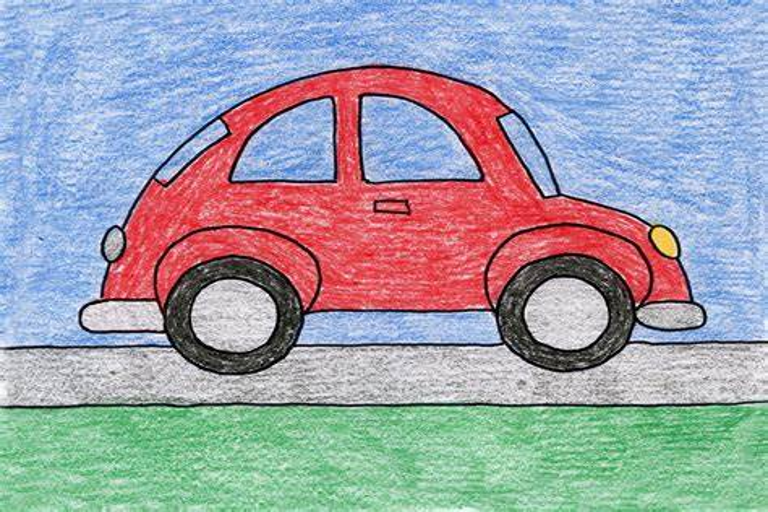

In [27]:
import requests
from io import BytesIO
from PIL import Image

url = "https://th.bing.com/th/id/OIP.ohGkZC2yTgsR4wv6GNnADAHaFu?pid=ImgDet&rs=1"

response = requests.get(url)
init_img = Image.open(BytesIO(response.content)).convert("RGB")
init_img = init_img.resize((768, 512))
init_img

In [28]:
#Define the prompt
prompt = "the offroad racing car"

In [29]:
generator = torch.Generator(device=device).manual_seed(1024)
with autocast("cuda"):
    image = pipe(prompt=prompt, image=init_img, strength=0.6, guidance_scale=7.5, generator=generator).images[0]

  0%|          | 0/30 [00:00<?, ?it/s]

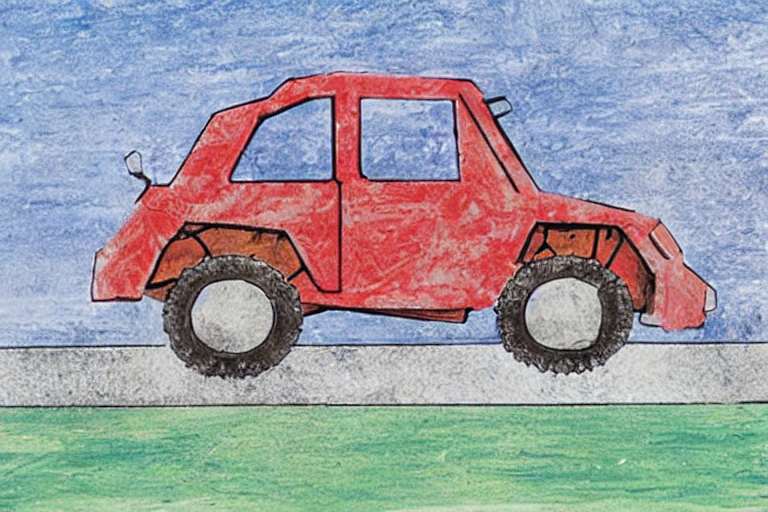

In [30]:
image

**Import Gradio framework and required dependencies**

In [31]:
!pip install gradio

In [32]:
import gradio as gr
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from PIL import Image as PILImage

**Define a folder to save the sketches**

In [33]:
save_folder = "/home/ochirpurev/sketches"  # Use an accessible directory in Colab
!mkdir -p $save_folder

**Define a prompt here**

In [81]:
prompt="the house in a countryside"

**Enhance Enhancer functio, where the user can directly upload the sketch**

In [94]:
def enhance_image_upload(sketch):
    # Generate a unique filename
    filename = f"{save_folder}/sketch.png"
    image_data = np.array(sketch)
    # extent = (0, sketch.width, 0, sketch.height)

    # Save the sketch as a PNG file
    plt.imsave(filename, image_data, cmap="viridis", origin="upper")
    
    # Open the saved image using PIL
    saved_image = PILImage.open(filename)
    saved_image = saved_image.convert("RGB").resize((512, 512)) 
    generator = torch.Generator(device=device).manual_seed(1024)
    with autocast("cuda"):
        return_image = pipe(prompt=prompt, image=saved_image, strength=0.65, guidance_scale=7.5, generator=generator).images[0]
    return return_image

In [95]:
def enhance_image_sketch(sketch):
    # Generate a unique filename
    filename = f"{save_folder}/sketch.png"
    image_data = np.array(sketch)
    # extent = (0, sketch.width, 0, sketch.height)

    # Save the sketch as a PNG file
    plt.imsave(filename, image_data, cmap="viridis", origin="upper")
    
    # Open the saved image using PIL
    saved_image = PILImage.open(filename)
    saved_image = saved_image.convert("RGB").resize((512, 512)) 
    generator = torch.Generator(device=device).manual_seed(1024)
    # return_image
    with autocast("cuda"):
        return_image = pipe(prompt=prompt, image=saved_image, strength=0.65, guidance_scale=7.5, generator=generator).images[0]

    return return_image

In [96]:
# unfinished iteratable version of the sketch enhancer 
# Initialize a variable to store the state
state = {"previous_output": None}

# Define your save_as_pil_image function
def save_as_pil_image_iterative(sketch):
    if state["previous_output"] is not None:
        # If there is a previous output, use it as input for the next iteration
        sketch = state["previous_output"]

    # Generate a unique filename
    filename = f"{save_folder}/sketch.png"
    image_data = np.array(sketch)

    # Save the sketch as a PNG file
    plt.imsave(filename, image_data, cmap="viridis", origin="upper")
    
    # Open the saved image using PIL
    saved_image = PILImage.open(filename)
    saved_image = saved_image.convert("RGB").resize((512, 512)) 
    generator = torch.Generator(device=device).manual_seed(1024)
    
    # Process the image with stable diffusion
    with autocast("cuda"):
        return_image = pipe(prompt=prompt, image=saved_image, strength=0.5, guidance_scale=7.5, generator=generator).images[0]

    # Update the state with the current output
    state["previous_output"] = return_image

    return return_image

**Run sketch_enhancer_upload function to debug the sketch_enhancer function without drawing the sketch**

In [97]:
sketch_enhancer_upload = gr.Interface(
    fn=enhance_image_upload, 
    inputs="image", 
    outputs="image").queue().launch(share=True, inline=False)

Running on local URL:  http://127.0.0.1:7889
Running on public URL: https://68f286a2a5aeccbecc.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


**Run the sketch_enhancer to draw the input sketch**

In [98]:
input_sketchpad =gr.Paint(label="Draw Here", brush_radius=4, type="pil", shape=(512, 512))
# sketch_enhancer = gr.Interface(fn=save_as_pil_image, inputs=input_sketchpad, outputs='image').queue().launch(share=True, inline=False)
sketch_enhancer = gr.Interface(
    fn=enhance_image_sketch, 
    inputs=input_sketchpad, 
    outputs='image', 
    live=True).queue().launch(share=True, inline=False)

Running on local URL:  http://127.0.0.1:7890
Running on public URL: https://db757b5de134e3dd44.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


  0%|          | 0/32 [00:00<?, ?it/s]